In [1]:
!pip install -q transformers matplotlib

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

MODEL_NAME = 'Qwen/Qwen2.5-32B-Instruct'

device = 'cuda'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.padding_side = "left"
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map='auto',
    dtype=torch.float16,
    trust_remote_code=True
)
model.eval()

Loading checkpoint shards:   0%|          | 0/17 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 5120)
    (layers): ModuleList(
      (0-63): 64 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=True)
          (k_proj): Linear(in_features=5120, out_features=1024, bias=True)
          (v_proj): Linear(in_features=5120, out_features=1024, bias=True)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=5120, out_features=27648, bias=False)
          (up_proj): Linear(in_features=5120, out_features=27648, bias=False)
          (down_proj): Linear(in_features=27648, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((5120,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((5120,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((5120,), eps=1e-06)
    (

In [10]:
BATCH_SIZE = 64
PRED_PATH = 'log_result_greedy_fix.txt'
GD_PATH = 'test.vi.txt'

In [8]:
def make_prompt(pred, tgt):
    prompt = f"""
You are an expert in evaluating English to Vietnamese translations.
For each example, compare the predicted translation (Prediction) with the reference translation (Ground Truth),
and provide only two numbers: Fluency and Adequacy, each on a 1-5 scale, separated by a space.
Fluency comes first, then Adequacy. Do NOT write anything else.

Example 1:
Prediction: "Xin chào, bạn khỏe không?"
Ground Truth: "Xin chào, bạn có khỏe không?"
Output: 5 4

Example 2:
Prediction: "Con mèo ngồi trên tấm thảm."
Ground Truth: "Con mèo đang ngồi trên thảm."
Output: 5 4

Now evaluate the following translation:

Prediction: "{pred}"
Ground Truth: "{tgt}"
Output:"""
    return prompt

In [11]:
fluencies = []
adequacies = []

with open(PRED_PATH, 'r', encoding='utf-8') as f:
    preds = f.read().splitlines()
with open(GD_PATH, 'r', encoding='utf-8') as f:
    tgts = f.read().splitlines()


def parse_output(text):
    try:
        text = text.split('Now evaluate the following translation:')[1].strip()
        text = text.split('Output:')[1].strip()
        fluency, adequacy = map(int, text.split()[:2])
    except:
        fluency, adequacy = -1, -1
    return fluency, adequacy


for i in tqdm(range(0, len(preds), BATCH_SIZE)):
    batch_preds = preds[i:i+BATCH_SIZE]
    batch_tgts = tgts[i:i+BATCH_SIZE]
    
    batch_prompts = [make_prompt(p, t) for p, t in zip(batch_preds, batch_tgts)]
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=8,
            do_sample=False
        )
    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    for text in decoded:
        f, a = parse_output(text)
        fluencies.append(f)
        adequacies.append(a)

100%|██████████| 25/25 [01:12<00:00,  2.90s/it]


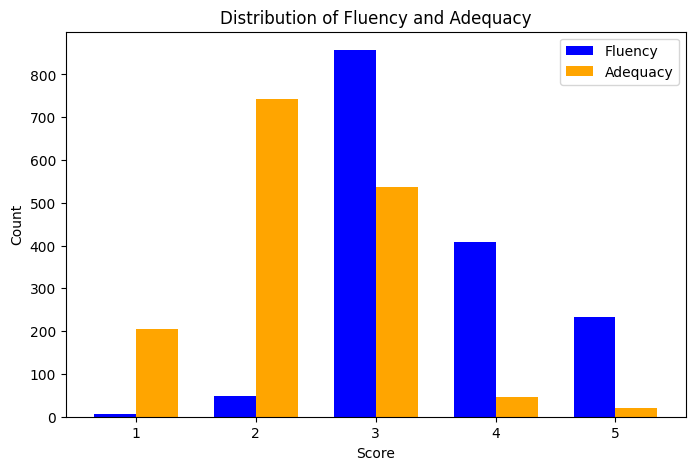

In [12]:
import matplotlib.pyplot as plt
from collections import Counter

fluency_counts = [fluencies.count(i) for i in range(1,6)]
adequacy_counts = [adequacies.count(i) for i in range(1,6)]

x = range(1,6)
width = 0.35

plt.figure(figsize=(8,5))
plt.bar([i - width/2 for i in x], fluency_counts, width=width, label='Fluency', color='blue')
plt.bar([i + width/2 for i in x], adequacy_counts, width=width, label='Adequacy', color='orange')

plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Fluency and Adequacy')
plt.xticks(x)
plt.legend()
plt.show()

In [13]:
print(f'AVG Fluency: {sum(fluencies) / len(fluencies):.2f}')
print(f'AVG Adequacy: {sum(adequacies) / len(adequacies):.2f}')

AVG Fluency: 3.52
AVG Adequacy: 2.31


In [14]:
BATCH_SIZE = 64
PRED_PATH = 'log_result_beam_fix.txt'
GD_PATH = 'test.vi.txt'

In [15]:
fluencies = []
adequacies = []

with open(PRED_PATH, 'r', encoding='utf-8') as f:
    preds = f.read().splitlines()
with open(GD_PATH, 'r', encoding='utf-8') as f:
    tgts = f.read().splitlines()


def parse_output(text):
    try:
        text = text.split('Now evaluate the following translation:')[1].strip()
        text = text.split('Output:')[1].strip()
        fluency, adequacy = map(int, text.split()[:2])
    except:
        fluency, adequacy = -1, -1
    return fluency, adequacy


for i in tqdm(range(0, len(preds), BATCH_SIZE)):
    batch_preds = preds[i:i+BATCH_SIZE]
    batch_tgts = tgts[i:i+BATCH_SIZE]
    
    batch_prompts = [make_prompt(p, t) for p, t in zip(batch_preds, batch_tgts)]
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=8,
            do_sample=False
        )
    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    for text in decoded:
        f, a = parse_output(text)
        fluencies.append(f)
        adequacies.append(a)

100%|██████████| 25/25 [01:12<00:00,  2.90s/it]


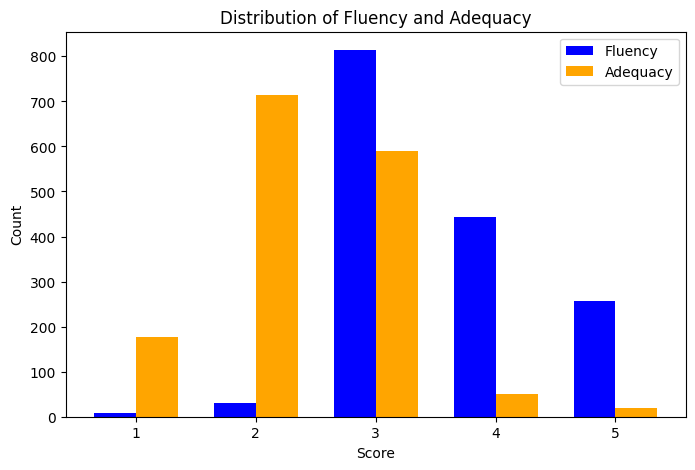

In [16]:
import matplotlib.pyplot as plt
from collections import Counter

fluency_counts = [fluencies.count(i) for i in range(1,6)]
adequacy_counts = [adequacies.count(i) for i in range(1,6)]

x = range(1,6)
width = 0.35

plt.figure(figsize=(8,5))
plt.bar([i - width/2 for i in x], fluency_counts, width=width, label='Fluency', color='blue')
plt.bar([i + width/2 for i in x], adequacy_counts, width=width, label='Adequacy', color='orange')

plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Fluency and Adequacy')
plt.xticks(x)
plt.legend()
plt.show()

In [17]:
print(f'AVG Fluency: {sum(fluencies) / len(fluencies):.2f}')
print(f'AVG Adequacy: {sum(adequacies) / len(adequacies):.2f}')

AVG Fluency: 3.59
AVG Adequacy: 2.37
